In [2]:
# Import Necessary Libraries:
! pip install facets-overview
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from graphviz import Source
from sklearn import tree
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from IPython.core.display import display, HTML
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import sklearn.metrics as metrics
import pickle
import time
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: C:\Users\wrksy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\wrksy\AppData\Local\Temp\ipykernel_2296\8996851.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Step 1: Data Loading

In [3]:
# Reading and Combining CSV Files:

# Multiple CSV files representing different days of traffic data are read in chunks to avoid memory issues. The chunks are combined into a single DataFrame and saved as a new file combined_dataset.csv.

# List of dataset files
csv_files = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

# Step 1: Load the dataset in chunks to avoid memory issues
chunk_size = 50000  # Adjust based on available memory
combined_chunks = []  # Store chunks temporarily

for file in csv_files:
    print(f"Processing {file}...")
    # Process in chunks to handle large files efficiently
    for chunk in pd.read_csv(file, chunksize=chunk_size, encoding='ISO-8859-1'):
        combined_chunks.append(chunk)

Processing Monday-WorkingHours.pcap_ISCX.csv...
Processing Tuesday-WorkingHours.pcap_ISCX.csv...
Processing Wednesday-workingHours.pcap_ISCX.csv...
Processing Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Processing Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Processing Friday-WorkingHours-Morning.pcap_ISCX.csv...
Processing Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Processing Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...


In [6]:
# Concatenate all chunks into a single DataFrame
combined_df = pd.concat(combined_chunks, ignore_index=True)

# Save the combined dataset to a new CSV file
combined_df.to_csv('combined_dataset.csv', index=False)

print("Combined dataset created successfully!")

Combined dataset created successfully!


# Step 2: Data Cleaning and Preprocessing

In [8]:
combined_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [12]:
# Strip any whitespace in column names
combined_df.columns = combined_df.columns.str.strip()
combined_df.shape

(2830743, 78)

In [13]:
combined_df['Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack ï¿½ Brute Force', 'Web Attack ï¿½ XSS',
       'Web Attack ï¿½ Sql Injection', 'Infiltration', 'Bot', 'PortScan',
       'DDoS'], dtype=object)

In [14]:
combined_df['Label'].value_counts()

Label
BENIGN                          2273097
DoS Hulk                         231073
PortScan                         158930
DDoS                             128027
DoS GoldenEye                     10293
FTP-Patator                        7938
SSH-Patator                        5897
DoS slowloris                      5796
DoS Slowhttptest                   5499
Bot                                1966
Web Attack ï¿½ Brute Force         1507
Web Attack ï¿½ XSS                  652
Infiltration                         36
Web Attack ï¿½ Sql Injection         21
Heartbleed                           11
Name: count, dtype: int64

In [16]:
print(combined_df.columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [17]:
# The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.
combined_df.replace('Infinity', -1, inplace=True)
combined_df[["Flow Bytes/s", "Flow Packets/s"]] = combined_df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

In [19]:
# Replace the NaN values and infinity values with -1.
combined_df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [20]:
# Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.
string_features = list(combined_df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

[]

In [21]:
le = preprocessing.LabelEncoder()
combined_df[string_features] = combined_df[string_features].apply(lambda col: le.fit_transform(col))

# 3. EDA & Data Visualization

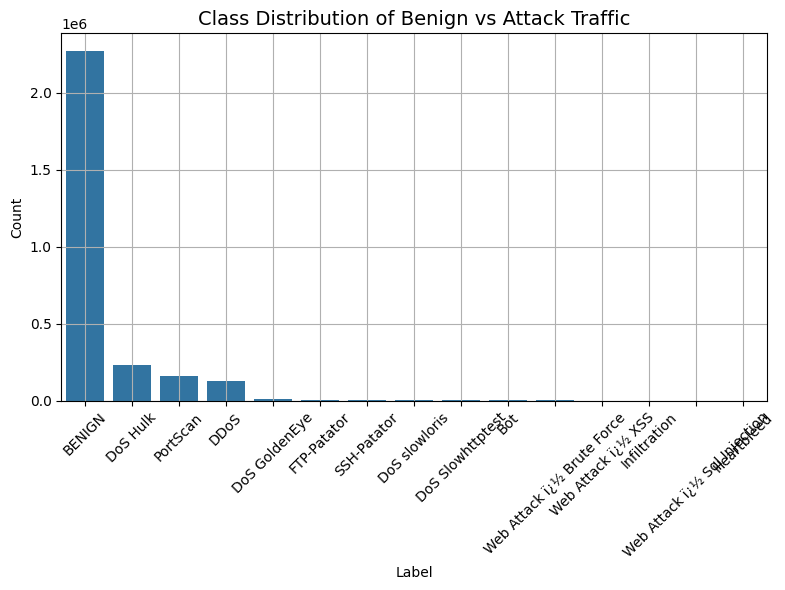

In [22]:
# Class Distribution of Benign vs Attack Traffic
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x='Label', order=combined_df['Label'].value_counts().index)
plt.title('Class Distribution of Benign vs Attack Traffic', fontsize=14)
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300)
plt.show()


C:\Users\wrksy\AppData\Local\Temp\ipykernel_2296\3525837517.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x='Label', order=ddos_attacks, palette='Blues_d')


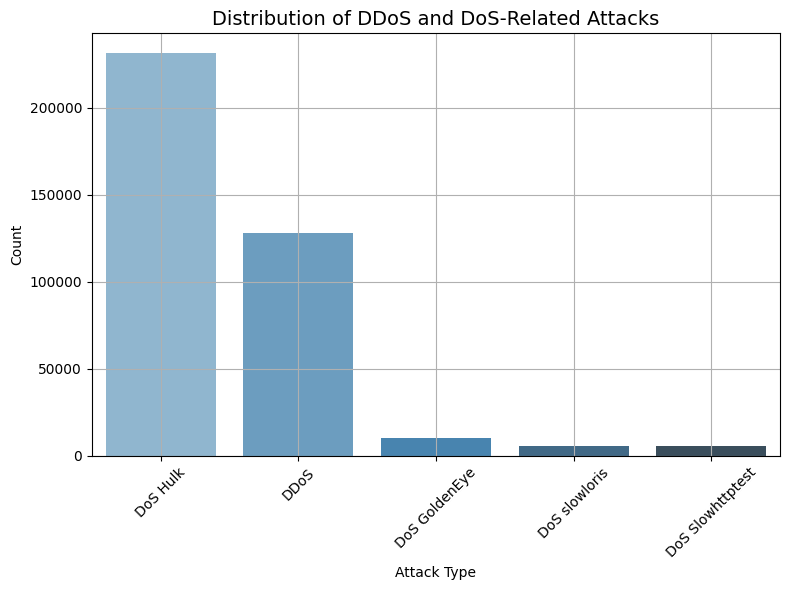

In [23]:
# Distribution of DDoS and DoS-Related Attacks
ddos_attacks = ['DoS Hulk', 'DDoS', 'DoS GoldenEye', 'DoS slowloris', 'DoS Slowhttptest']

# Filter the combined_df dataset for these specific attack types
filtered_df = combined_df[combined_df['Label'].isin(ddos_attacks)]

# Plotting the bar chart for DDoS and DoS-related attacks
plt.figure(figsize=(8, 6))
sns.countplot(data=filtered_df, x='Label', order=ddos_attacks, palette='Blues_d')

# Customizing the plot
plt.title('Distribution of DDoS and DoS-Related Attacks', fontsize=14)
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# 4. Feature Engineering

C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


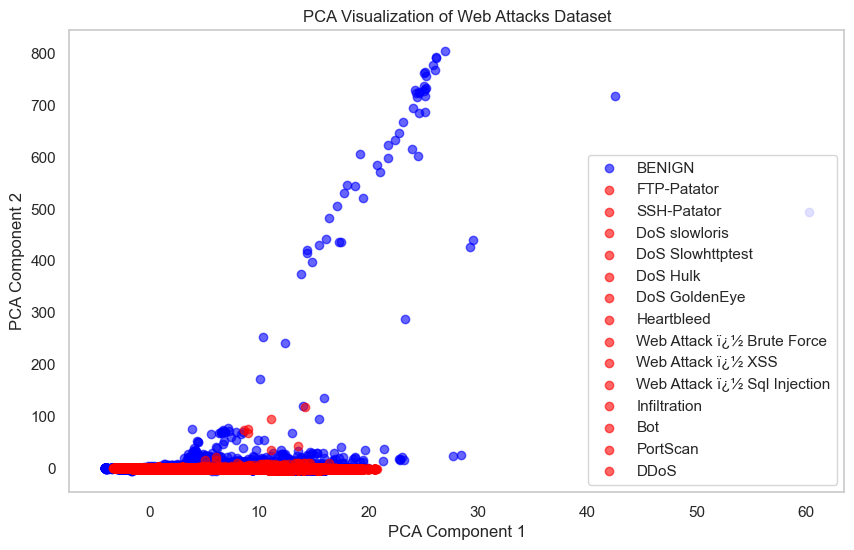

Explained variance ratio by each component:
[0.21942565 0.10409477]


In [135]:
# Separate features and labels
X = combined_df.drop('Label', axis=1)  
y = combined_df['Label']                

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['Label'] = y.reset_index(drop=True)  

# Plotting the PCA results
plt.figure(figsize=(10, 6))
colors = {'BENIGN': 'blue', 'ATTACK': 'red'}

# Separate the different attack types
for label in pca_df['Label'].unique():
    plt.scatter(pca_df[pca_df['Label'] == label]['PCA Component 1'],
                pca_df[pca_df['Label'] == label]['PCA Component 2'],
                c=colors.get(label, 'red'),  
                label=label, alpha=0.6)

plt.title('PCA Visualization of Web Attacks Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

# Print explained variance ratio
print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)


C:\Users\wrksy\AppData\Local\Temp\ipykernel_2296\2479843064.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x='Label', order=combined_df['Label'].value_counts().index, palette=palette)


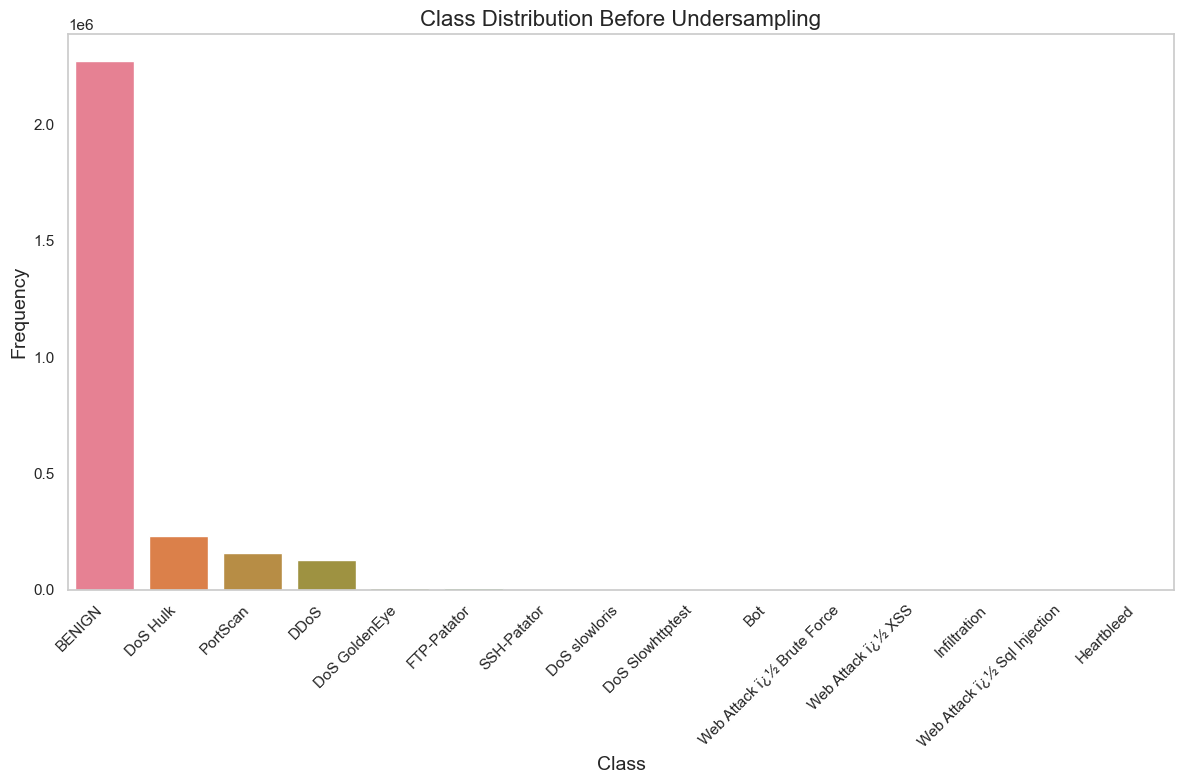

In [49]:
# Count plot for class distribution before undersampling
sns.set(style="whitegrid")

# Create a color palette for the labels
palette = sns.color_palette("husl", len(combined_df['Label'].unique()))

# Count plot for class distribution before undersampling
plt.figure(figsize=(12, 8))
sns.countplot(data=combined_df, x='Label', order=combined_df['Label'].value_counts().index, palette=palette)

# Customizing the plot
plt.title('Class Distribution Before Undersampling', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
### Undersampling against unbalance, I use undersampling to correct class imbalances: we remove most of the "BENIGN" records.
# Count the total number of benign and attack records
benign_total = len(combined_df[combined_df['Label'] == "BENIGN"])
attack_total = len(combined_df[combined_df['Label'] != "BENIGN"])

print("Total Benign Records:", benign_total)
print("Total Attack Records:", attack_total)

Total Benign Records: 2273097
Total Attack Records: 557646


In [27]:
# Determine the number of benign records to keep (e.g., equal to the number of attack records)
# For example, we keep the same number of benign records as there are attack records

benign_to_keep = attack_total  

# Randomly select benign records to undersample
benign_sampled = combined_df[combined_df['Label'] == "BENIGN"].sample(n=benign_to_keep, random_state=42)

# Combine the sampled benign records with all attack records
combined_balanced_df = pd.concat([benign_sampled, combined_df[combined_df['Label'] != "BENIGN"]])

# Shuffle the combined DataFrame 
combined_balanced_df = combined_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [55]:
# Save the balanced dataset to a new CSV file
combined_balanced_df.to_csv("web_attacks_balanced.csv", index=False)

# Display the value counts of the balanced dataset
print("Balanced class distribution:")
print(combined_balanced_df['Label'].value_counts())

Balanced class distribution:
Label
BENIGN                          557646
DoS Hulk                        231073
PortScan                        158930
DDoS                            128027
DoS GoldenEye                    10293
FTP-Patator                       7938
SSH-Patator                       5897
DoS slowloris                     5796
DoS Slowhttptest                  5499
Bot                               1966
Web Attack ï¿½ Brute Force        1507
Web Attack ï¿½ XSS                 652
Infiltration                        36
Web Attack ï¿½ Sql Injection        21
Heartbleed                          11
Name: count, dtype: int64


C:\Users\wrksy\AppData\Local\Temp\ipykernel_2296\1998228007.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_balanced_df, x='Label', order=combined_balanced_df['Label'].value_counts().index, palette=palette)


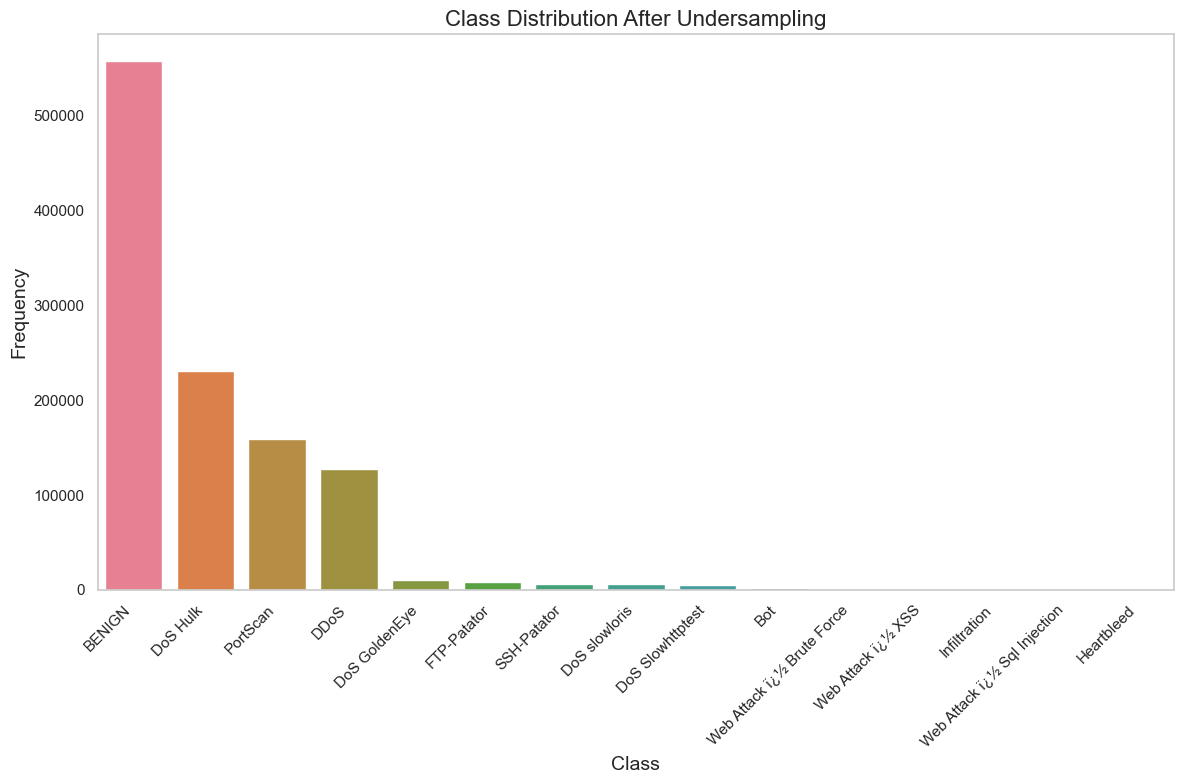

In [56]:
# Count plot for class distribution After undersampling
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a color palette for the labels
palette = sns.color_palette("husl", len(combined_balanced_df['Label'].unique()))

# Count plot for class distribution after undersampling
plt.figure(figsize=(12, 8))
sns.countplot(data=combined_balanced_df, x='Label', order=combined_balanced_df['Label'].value_counts().index, palette=palette)

# Customizing the plot
plt.title('Class Distribution After Undersampling', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

Balanced class distribution after combining DDoS attacks:
Label
BENIGN                          557646
DDoS Attacks                    380688
PortScan                        158930
FTP-Patator                       7938
SSH-Patator                       5897
Bot                               1966
Web Attack ï¿½ Brute Force        1507
Web Attack ï¿½ XSS                 652
Infiltration                        36
Web Attack ï¿½ Sql Injection        21
Heartbleed                          11
Name: count, dtype: int64


C:\Users\wrksy\AppData\Local\Temp\ipykernel_2296\4184508562.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_balanced_df, x='Label', palette='viridis')


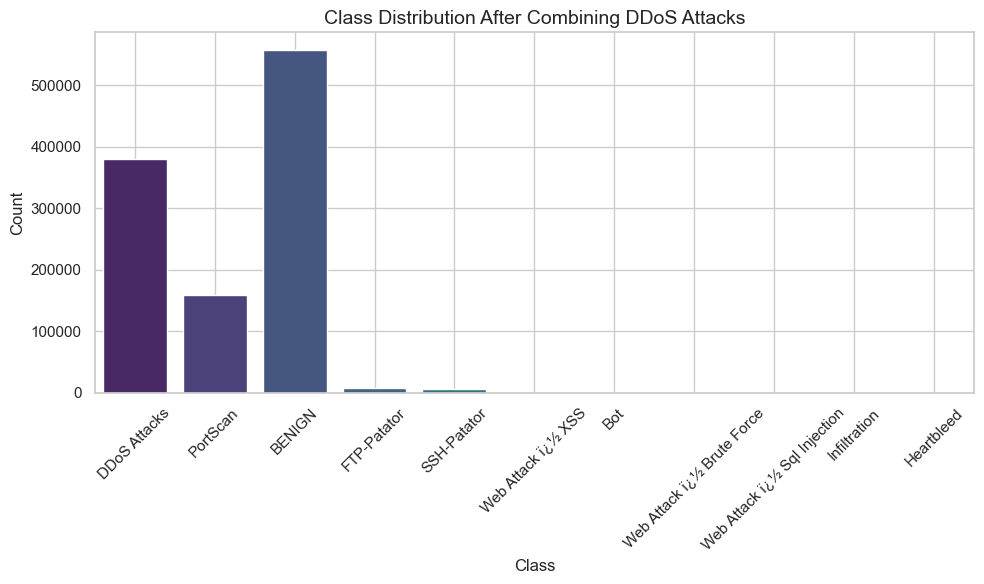

In [57]:
# Combine DDoS-related attack classes into one
ddos_related_classes = ['DDoS', 'DoS Hulk', 'DoS GoldenEye', 'DoS slowloris', 'DoS Slowhttptest']
combined_balanced_df['Label'] = combined_balanced_df['Label'].replace(ddos_related_classes, 'DDoS Attacks')

# Display the updated balanced class distribution
print("Balanced class distribution after combining DDoS attacks:")
print(combined_balanced_df['Label'].value_counts())

# Plot class distribution after combining DDoS attacks
plt.figure(figsize=(10, 6))

# Using Seaborn for a better visual representation
sns.countplot(data=combined_balanced_df, x='Label', palette='viridis')
plt.title('Class Distribution After Combining DDoS Attacks', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# 4. Exploratory Data Analysis (EDA)

In [58]:
## Сalculate the probability of copying a "BENIGN" record. The enlargement multiplier is used to get exactly 70% benign data.
""" Goal:

To reduce the imbalance between the benign and attack records in the dataset.
I want exactly 70% of the data to consist of benign records, and the remaining 30% to consist of attack records. """

enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

1301174.0 0.6296657819705891


In [61]:
# Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.
""" Ensure 70/30 Class Distribution:

The logic for the 70% benign and 30% attack records is maintained. Once the limit (benign_included_max) is reached, no further benign records are added to df_balanced. This maintains the intended balance in the final dataset.
     """
indexes = []
benign_included_count = 0
for index, row in combined_balanced_df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have I achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = combined_df.loc[indexes]

In [62]:
df_balanced['Label'].value_counts()

Label
BENIGN              837851
DoS Hulk             49978
FTP-Patator           6499
SSH-Patator           4827
DoS slowloris         4727
DoS Slowhttptest      4458
Name: count, dtype: int64

In [136]:
# Keeping a single class of attack for experiments.
""" Remove the records associated with certain attack types (in this case, "Web Attack – Brute Force" and "Web Attack – SQL Injection").
This is done to reduce the complexity of the dataset and focus experiments on remaining attack types, which are particularly useful to study the model's performance on a specific subset of attack classes.
 """

df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
df_balanced['Label'].value_counts()

Label
BENIGN              837851
DoS Hulk             49978
FTP-Patator           6499
SSH-Patator           4827
DoS slowloris         4727
DoS Slowhttptest      4458
Name: count, dtype: int64

In [64]:
# Preservation of Processed Data:
""" By saving the dataset as "web_attacks_balanced.csv", I ensure that the processed data can be reused in the future without needing to repeat the entire data preprocessing pipeline. """

df_balanced.to_csv("web_attacks_balanced.csv", index=False)

In [65]:
### Preparing data for training
# Memory Efficiency
""" This implementation of chunked loading allows you to safely and efficiently load large datasets, like the balanced web attacks dataset, into memory without exceeding the system’s capacity. 
 """

chunk_size = 50000  

# Initialize an empty list to store the chunks
chunks = []

# Read the CSV file in chunks
for chunk in pd.read_csv('web_attacks_balanced.csv', chunksize=chunk_size, encoding='ISO-8859-1'):
    chunks.append(chunk)

# Concatenate the chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Check the shape of the combined DataFrame
print("Data loaded successfully with shape:", df.shape)


Data loaded successfully with shape: (908340, 78)


In [66]:
# The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

""" Binary Classification:

By encoding "BENIGN" as 0 and any attack as 1, you set up the problem as a binary classification task. In this case, the model is trained to differentiate between two classes:
Class 0 (BENIGN): Normal network behavior.
Class 1 (ATTACK): Abnormal or malicious network behavior (any kind of attack).
 """
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [67]:
"""  Remove irrelevant columns that are redundant, or likely to cause overfitting. By dropping these columns, I ensure that the machine learning model can focus on the actual patterns of network traffic that indicate whether the traffic is benign or an attack, leading to better generalization, reduced noise, and improved performance. """

excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

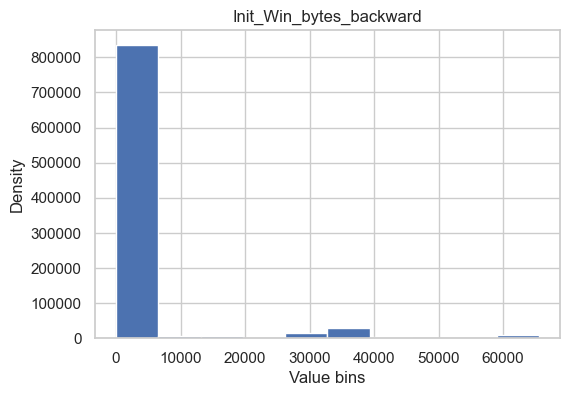

In [68]:
# Visualizing Feature Distribution:
"""
The Init_Win_bytes_backward column likely contains numeric values representing initial window sizes in a backward direction (i.e., from the destination to the source). 
This help to visualize data distribution, which provides insight into the data, such as:
1. Whether the feature is normally distributed, skewed, or contains outliers.
2. Whether the range of values is reasonable or if certain values are disproportionately represented.


"""

if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

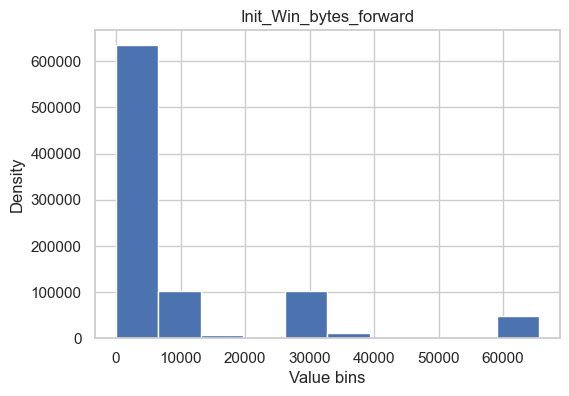

In [69]:
# Understanding Data Distribution:

""" Similar to the Init_Win_bytes_backward feature, I want to know how the values in the Init_Win_bytes_forward column are distributed. """

if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [70]:
""" After analyzing the distributions of the Init_Win_bytes_backward and Init_Win_bytes_forward columns (using histograms), I found out that they are not contributing useful information (heavily skewed, dominated by zeros, between classes), then it makes sense to remove them. """

excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2, errors='ignore')

In [139]:
# Preparing your dataset for training a machine learning model. 

"""
Here, I am separating the features (X) from the target labels (y), which is a crucial step in supervised learning tasks like classification. """

y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(908340, 77) (908340,)


# Model Training Training and Testing Separation

In [149]:
# Splitting the data into training and testing sets
# X: Features, y: Target labels (0 for BENIGN, 1 for ATTACK)
# test_size=0.3 means 30% of the data will be used for testing, and 70% for training
# random_state=42 ensures the split is reproducible across different runs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
# Evaluate the model using 10-fold cross-validation to assess its generalization performance.
# This helps ensure the model doesn't overfit and provides a robust estimate of its accuracy on unseen data.

cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.97360971, 0.97382989, 0.9740658 , 0.97326371, 0.97401862,
       0.97364117, 0.97298062, 0.9727919 , 0.97299593, 0.97461586])

In [150]:
# Visualize the structure of a trained Decision Tree model in a human-readable text format. Here’s a step-by-step breakdown of the implementation

from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Bwd Packet Length Std <= 1545.93
|   |--- Destination Port <= 32.00
|   |   |--- min_seg_size_forward <= 26.00
|   |   |   |--- class: 0
|   |   |--- min_seg_size_forward >  26.00
|   |   |   |--- class: 1
|   |--- Destination Port >  32.00
|   |   |--- Active Max <= 6405175.50
|   |   |   |--- class: 0
|   |   |--- Active Max >  6405175.50
|   |   |   |--- class: 1
|--- Bwd Packet Length Std >  1545.93
|   |--- class: 1



In [151]:
# Export decision tree as a dot file format, and render using graphviz
dot_data = tree.export_graphviz(
    decision_tree, 
    out_file=None,  # No need to write to a file
    feature_names=X.columns,  # Ensure X is a DataFrame with column names
    filled=True,  # Option to fill colors in nodes based on class predictions
    rounded=True,  # Rounded corners for aesthetics
    special_characters=True 
)

# Create and display the graph
graph = Source(dot_data)
graph.render("decision_tree")  
graph.view() 


'decision_tree.pdf'

In [152]:
## Analyze the confusion matrix. Which classes are confidently classified by the model?
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 251411, 1: 21091}

In [153]:
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[249304,   2107],
       [  5100,  15991]], dtype=int64)

In [154]:
# This code performs automatic feature selection based on the importance of features as determined by the trained Decision Tree model.
# It uses SelectFromModel to fit the model to the training data and retains only the most important features, reducing the feature space.
# The feature importance scores from the Decision Tree are extracted to show how much each feature contributes to the model's decision-making.

from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.15491789, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.76041615, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03969954, 0.        ,
       0.        , 0.04496641, 0.        , 0.        , 0.     

In [155]:
# The threshold value used for feature selection, which determines the minimum importance score a feature must have to be retained.
# Features with importance scores greater than or equal to this threshold are kept, while others are discarded.
sfm.threshold_

0.012987012987012988

In [156]:
# Apply feature selection to the training data, keeping only the most important features identified by SelectFromModel.
# This transforms X_train by reducing it to the selected feature set.
# Print the original number of features and the reduced number of features after selection to verify the dimensionality reduction.

X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 77, selected num features: 4


In [157]:
# Sort the features by their importance scores in descending order based on the decision tree's feature_importances_.
# Then, iterate through the top 10 most important features, printing their rank, name, and importance score.
# This helps to identify which features contribute the most to the model's predictions and provides insights for feature selection or further model tuning.

indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Bwd Packet Length Std - 0.7604161549365557
1.	Destination Port - 0.1549178944301729
2.	Active Max - 0.04496640829488207
3.	min_seg_size_forward - 0.03969954233838931
4.	Bwd IAT Mean - 0.0
5.	Fwd IAT Total - 0.0
6.	Fwd IAT Mean - 0.0
7.	Fwd IAT Std - 0.0
8.	Fwd IAT Max - 0.0
9.	Fwd IAT Min - 0.0


In [158]:
rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 1.00 
R^2 Validation Score: 1.00 
Out-of-bag Score: 1.00


In [159]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:20]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#0	0.098	Destination Port
2.	#54	0.063	Avg Bwd Segment Size
3.	#13	0.062	Bwd Packet Length Std
4.	#41	0.054	Packet Length Std
5.	#42	0.053	Packet Length Variance
6.	#12	0.053	Bwd Packet Length Mean
7.	#10	0.042	Bwd Packet Length Max
8.	#65	0.033	Init_Win_bytes_forward
9.	#39	0.030	Max Packet Length
10.	#34	0.025	Fwd Header Length
11.	#52	0.024	Average Packet Size
12.	#5	0.022	Total Length of Bwd Packets
13.	#18	0.022	Flow IAT Max
14.	#22	0.022	Fwd IAT Std
15.	#40	0.020	Packet Length Mean
16.	#68	0.019	min_seg_size_forward
17.	#23	0.018	Fwd IAT Max
18.	#16	0.017	Flow IAT Mean
19.	#35	0.017	Bwd Header Length
20.	#15	0.016	Flow Packets/s


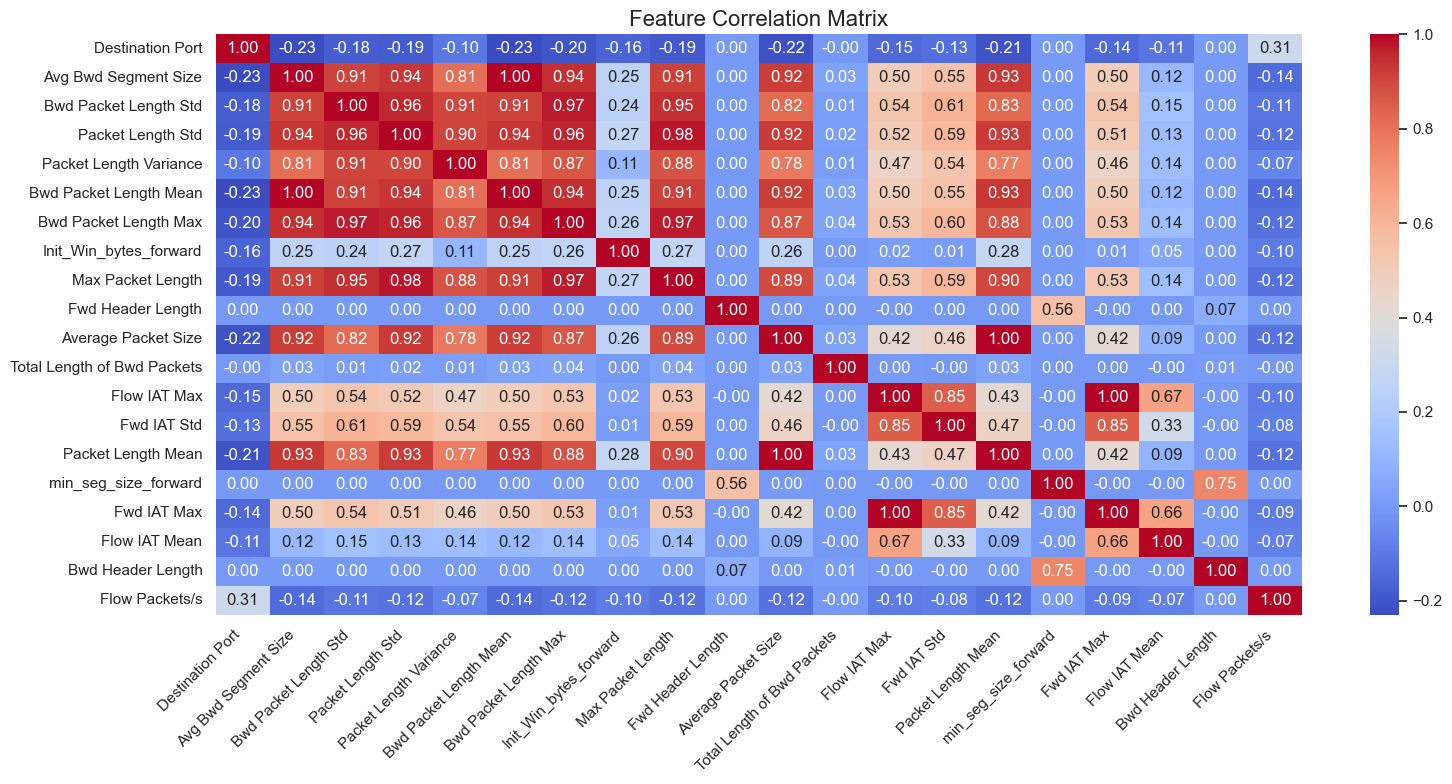

In [160]:
plt.figure(figsize=(16, 8))
corr_matrix = df[webattack_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()


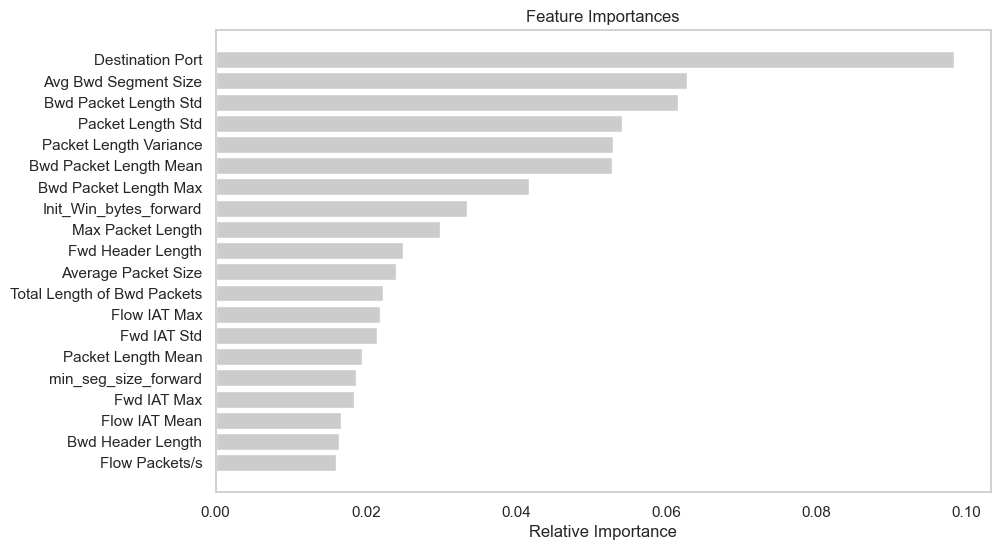

In [161]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [162]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[251376,     35],
       [    57,  21034]], dtype=int64)

In [163]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Destination Port',
 'Avg Bwd Segment Size',
 'Bwd Packet Length Std',
 'Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Max',
 'Init_Win_bytes_forward',
 'Max Packet Length',
 'Fwd Header Length',
 'Average Packet Size',
 'Total Length of Bwd Packets',
 'Flow IAT Max',
 'Fwd IAT Std',
 'Packet Length Mean',
 'min_seg_size_forward',
 'Fwd IAT Max',
 'Flow IAT Mean',
 'Bwd Header Length',
 'Flow Packets/s']

## Analysis of selected features

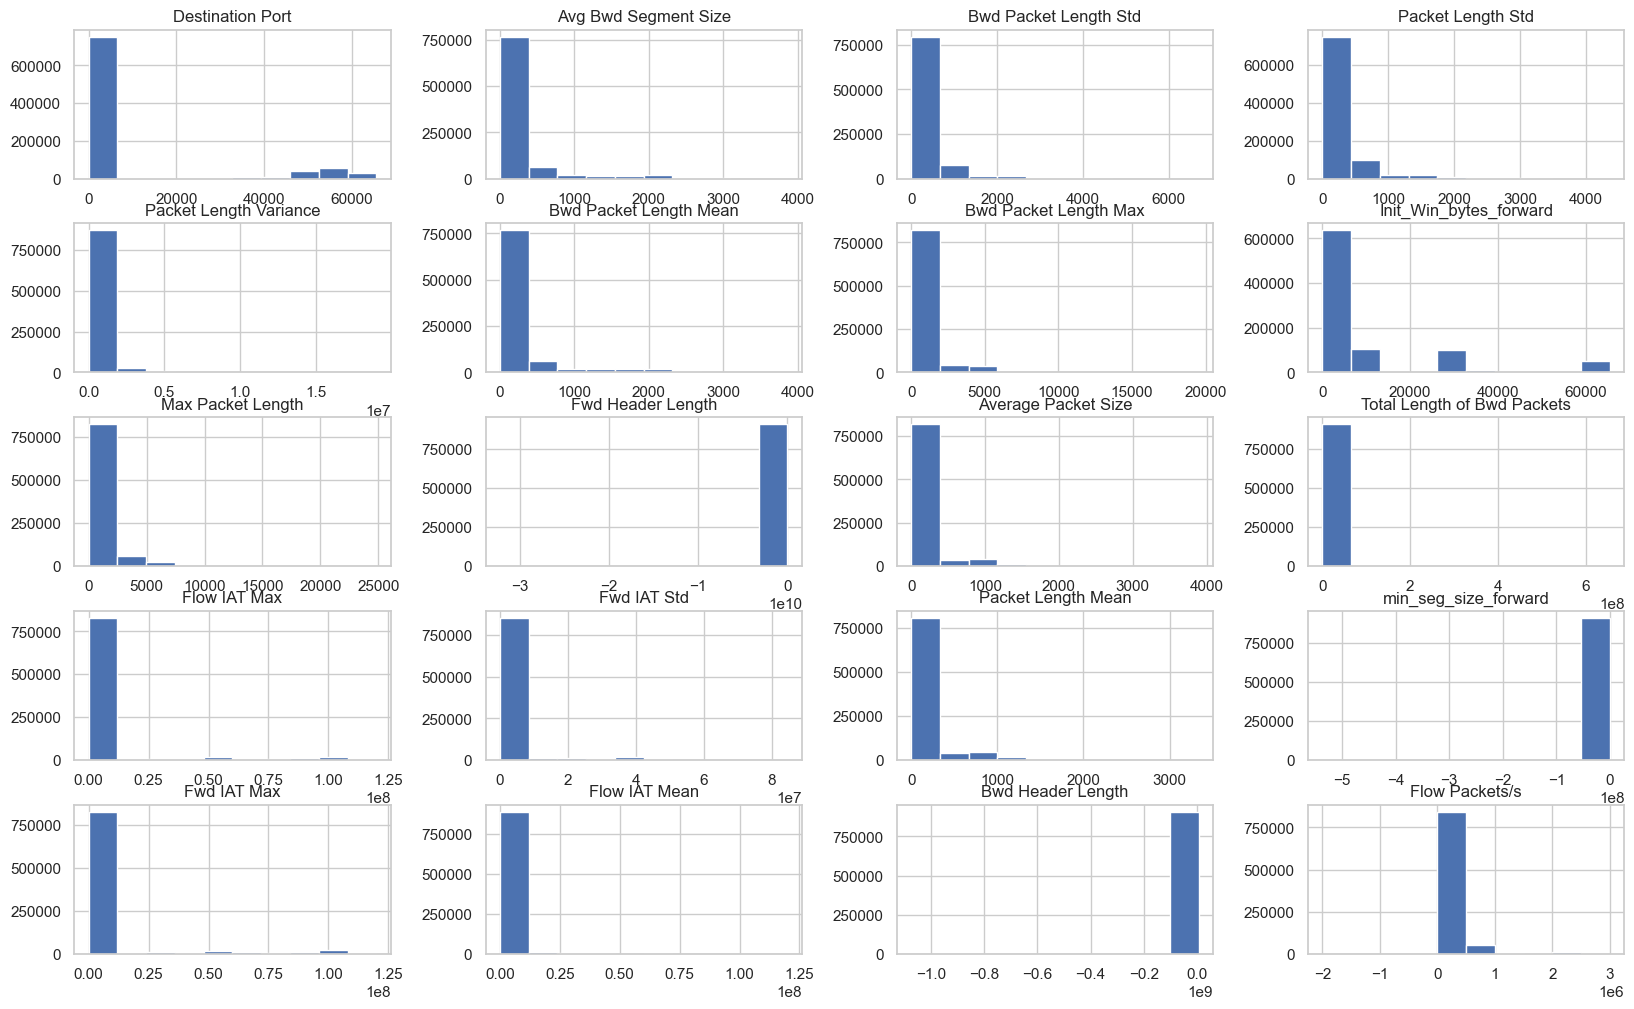

In [164]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

In [165]:
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train + test', 'table': df[webattack_features]}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


In [166]:
## Display the facets overview visualization for this data.
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [167]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes',
                 'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Destination Port',
 'Avg Bwd Segment Size',
 'Bwd Packet Length Std',
 'Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Max',
 'Init_Win_bytes_forward',
 'Max Packet Length',
 'Fwd Header Length']

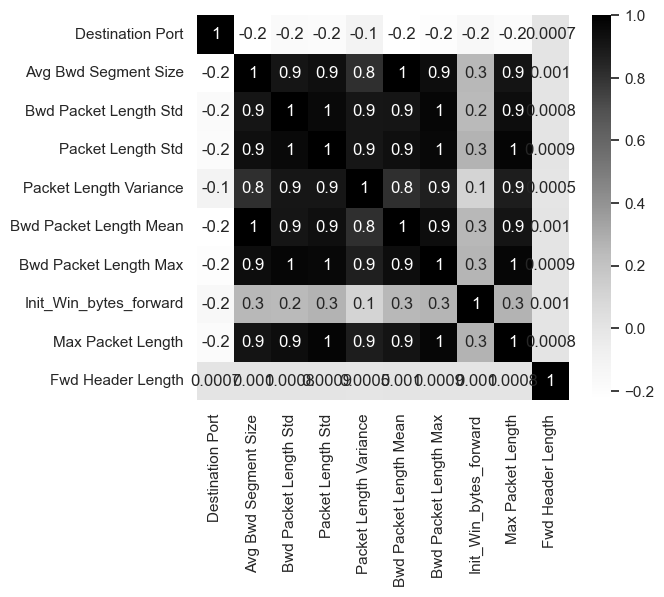

In [168]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys');

## Hyperparameter selection

In [169]:
## Reopen the dataset.
df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(908340, 10) (908340,)


In [171]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

# For search of quasi-optimal value of one parameter we fix the others.

In [172]:
# Define parameter grid
parameters = {
    'n_estimators': [10],
    'min_samples_leaf': [3],
    'max_features': [3],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 20, 30, 50]
}

# Define scoring metrics
scoring = ['f1', 'accuracy']  # Should be a list, not a set

# Create GridSearchCV object
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)

# Fit the model (this can take some time depending on your data and parameters)
import time
start_time = time.time()
gcv.fit(X, y)
print(f"Grid search completed in {time.time() - start_time} seconds")

# Get the results
results = gcv.cv_results_


Grid search completed in 1280.0586881637573 seconds


In [173]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_f1,...,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy
0,1.721854,0.101592,0.039910,0.007056,1,3,3,10,"{'max_depth': 1, 'max_features': 3, 'min_sampl...",0.000000,...,0.966269,0.959565,0.959701,0.960083,0.960658,0.960803,0.960651,0.961868,0.962334,0.002907
1,2.998390,0.167246,0.050413,0.010571,2,3,3,10,"{'max_depth': 2, 'max_features': 3, 'min_sampl...",0.000000,...,0.968427,0.961761,0.961918,0.962124,0.962338,0.962937,0.962833,0.962996,0.964325,0.002946
2,3.851812,0.344238,0.044753,0.007944,3,3,3,10,"{'max_depth': 3, 'max_features': 3, 'min_sampl...",0.000000,...,0.972486,0.965778,0.965955,0.966184,0.966357,0.966970,0.966825,0.967100,0.967983,0.002563
3,4.927850,0.364186,0.049065,0.012739,4,3,3,10,"{'max_depth': 4, 'max_features': 3, 'min_sampl...",0.000000,...,0.976530,0.978010,0.977897,0.978423,0.978819,0.978993,0.978774,0.979358,0.977899,0.001874
4,5.970568,0.295632,0.060444,0.017336,5,3,3,10,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.657795,...,0.980359,0.978856,0.979011,0.979214,0.979384,0.979996,0.979818,0.980099,0.979601,0.000753


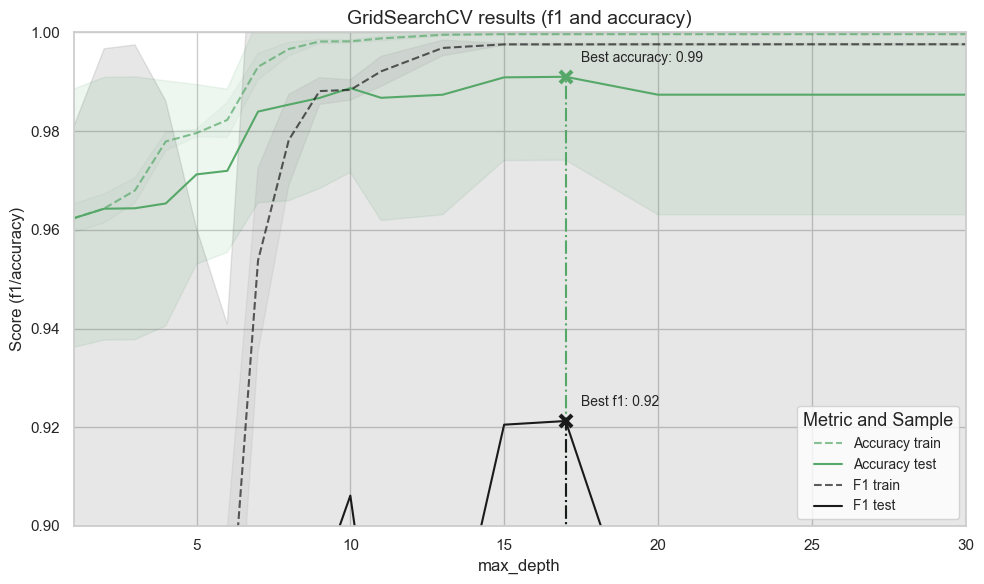

In [174]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html

plt.figure(figsize=(10, 6))  # Slightly larger plot for better readability
plt.title("GridSearchCV results (f1 and accuracy)", fontsize=14)

plt.xlabel("max_depth", fontsize=12)
plt.ylabel("Score (f1/accuracy)", fontsize=12)

ax = plt.gca()
ax.set_xlim(1, 30)  # Limit depth range
ax.set_ylim(0.9, 1)  # Adjust y-axis dynamically if needed

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]

        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0.05, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s %s" % (scorer.capitalize(), sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot vertical line for the best score
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score
    ax.annotate(f"Best {scorer}: %0.2f" % best_score,
                (X_axis[best_index] + 0.5, best_score + 0.003), fontsize=10)

# Enhanced legend
plt.legend(loc="best", fontsize=10, title="Metric and Sample", title_fontsize='13')
plt.grid(True)  # Enable gridlines for readability
plt.tight_layout()  # Ensure labels are not cut off

# Save the figure with higher resolution for better presentation
plt.savefig('GridSearchCV_results_enhanced.png', dpi=300)
plt.show()


### Grid search

In [175]:
parameters = {'n_estimators': [30, 50, 70],
              'min_samples_leaf': [3, 5, 7],
              'max_features': [3, 5, 7, 10],
              'max_depth': [10, 17, 23]}

# parameters = {'n_estimators': [250]}

In [176]:
# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    rfc, 
    parameters, 
    scoring=scoring, 
    refit='f1', 
    cv=3, 
    return_train_score=True,
    n_iter=10,  
    random_state=42  
)
get_ipython().run_line_magic('time', 'random_search.fit(X, y)')

CPU times: total: 11min 25s
Wall time: 35min 43s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   param_distributions={'max_depth': [10, 17, 23],
                                        'max_features': [3, 5, 7, 10],
                                        'min_samples_leaf': [3, 5, 7],
                                        'n_estimators': [30, 50, 70]},
                   random_state=42, refit='f1', return_train_score=True,
                   scoring=['f1', 'accuracy'])

# Let's take a look at the results of the parameter selection.

In [177]:
gcv.best_estimator_

RandomForestClassifier(max_depth=17, max_features=3, min_samples_leaf=3,
                       n_estimators=10, random_state=1)

In [178]:
gcv.best_params_

{'max_depth': 17, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 10}

In [179]:
gcv.best_score_

0.9212615808274809

In [180]:
## Final model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(635838, 10) (635838,)
(272502, 10) (272502,)


In [181]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
# rfc = RandomForestClassifier(n_estimators=250, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [182]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#2	0.522	Bwd Packet Length Std
2.	#0	0.195	Destination Port
3.	#9	0.128	Fwd Header Length
4.	#7	0.081	Init_Win_bytes_forward
5.	#8	0.018	Max Packet Length
6.	#5	0.015	Bwd Packet Length Mean
7.	#3	0.014	Packet Length Std
8.	#4	0.013	Packet Length Variance
9.	#1	0.012	Avg Bwd Segment Size
10.	#6	0.003	Bwd Packet Length Max


In [183]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[251332,     79],
       [    44,  21047]], dtype=int64)

In [184]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9995486271660391
Precision = 0.9962605320458203
Recall = 0.9979138020956806
F1 = 0.9970864817490585


## Model saving

In [185]:
with open('webattack_detection_rf_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

## Model approbation

# Open the previously saved model.

In [186]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

Reopen the dataset.

In [187]:
df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = df['Label'].values
X_test = df[webattack_features]
print(X_test.shape, y_test.shape)

(908340, 10) (908340,)


In [188]:
seconds = time.time()
y_pred = rfc.predict(X_test)
print("Total operation time:", time.time() - seconds, "seconds")

print("Benign records detected (0), attacks detected (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Total operation time: 2.139152765274048 seconds
Benign records detected (0), attacks detected (1):


{0: 837729, 1: 70611}

In [189]:
confusion_matrix(y_test, y_pred)

array([[837598,    253],
       [   131,  70358]], dtype=int64)

In [190]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9995772508091684
Precision = 0.9964169888544278
Recall = 0.9981415540013335
F1 = 0.9972785258681786


In [191]:
predict = pd.DataFrame({'Predict': rfc.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
result = X_test.join(label).join(predict)

In [192]:
result[result['Predict'] == 1]

,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Std,Packet Length Std,Packet Length Variance,Bwd Packet Length Mean,Bwd Packet Length Max,Init_Win_bytes_forward,Max Packet Length,Fwd Header Length,Label,Predict
4145,80,0.000000,0.000000,0.000000,0.000,0.000000,0,251,0,64,0,1
4310,80,0.000000,0.000000,0.000000,0.000,0.000000,0,251,0,128,0,1
4968,80,0.000000,0.000000,0.000000,0.000,0.000000,0,251,0,96,0,1
4982,80,0.000000,0.000000,0.000000,0.000,0.000000,0,274,0,64,0,1
5182,80,0.000000,0.000000,0.000000,0.000,0.000000,0,274,0,64,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
908335,80,1449.375000,1729.380148,1380.034648,1904495.629,1449.375000,4344,0,4344,196,1,1
908336,80,1656.428571,2120.732252,1609.482431,2590433.695,1656.428571,5792,0,5792,196,1,1
908337,80,1656.428571,1947.638216,1437.734114,2067079.382,1656.428571,5792,274,5792,296,1,1
908338,80,1932.500000,4060.245892,2597.870122,6748929.171,1932.500000,10136,0,10136,228,1,1


In [193]:
# Scale the features
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the ANN model architecture
model = Sequential()

In [194]:
# Input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))


C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [195]:
# Second hidden layer
model.add(Dense(units=32, activation='relu'))

In [196]:
# Output layer
model.add(Dense(units=1, activation='sigmoid'))

In [197]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [203]:
# Train the model and save training history
history = model.fit(X_train, y_train, epochs=9, batch_size=32, validation_split=0.2)

# Plot loss and accuracy over epochs
plt.figure(figsize=(12, 5))

Epoch 1/9
15896/15896 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.9748 - loss: 0.0463 - val_accuracy: 0.9774 - val_loss: 0.0449
Epoch 2/9
15896/15896 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.9753 - loss: 0.0458 - val_accuracy: 0.9796 - val_loss: 0.0464
Epoch 3/9
15896/15896 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.9755 - loss: 0.0452 - val_accuracy: 0.9702 - val_loss: 0.0444
Epoch 4/9
15896/15896 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.9758 - loss: 0.0452 - val_accuracy: 0.9760 - val_loss: 0.0436
Epoch 5/9
15896/15896 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.9758 - loss: 0.0446 - val_accuracy: 0.9777 - val_loss: 0.0431
Epoch 6/9
15896/15896 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.9756 - loss: 0.0446 - val_accuracy: 0.9792 - val_loss: 0.0436
Epoch 7/9
15896/15896 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.9763 - loss: 0.0442 - val_accuracy: 0.9744 - val_loss: 0.0441
Epoch 8/9
15896/15896 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9758 -

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

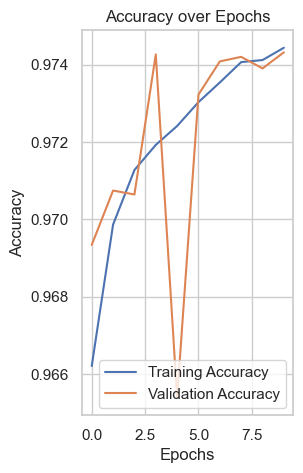

In [199]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

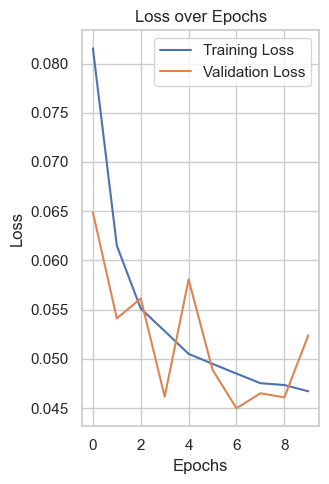

In [200]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [201]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

28386/28386 ━━━━━━━━━━━━━━━━━━━━ 22s 767us/step


Accuracy: 0.9745282603430434
Precision: 0.9892948664958254
Recall: 0.6791130531004838
F1 Score: 0.8053702566518334


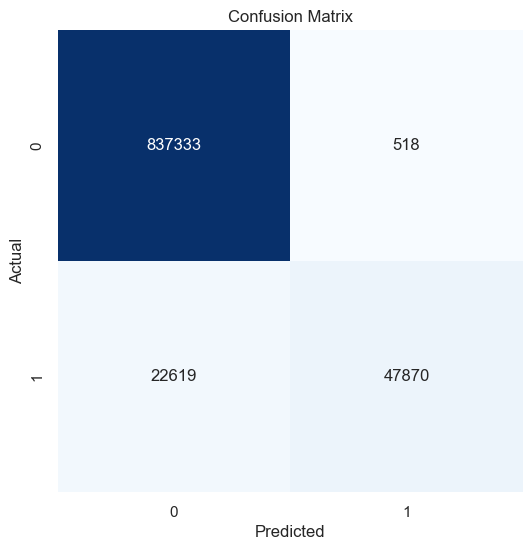

In [202]:
# Print evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
